In [1]:
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration
import warnings
warnings.filterwarnings('ignore')

# Kendi modüllerimizi import et
from src.data_loader import EcommerceDataLoader
from src.genai_utils import ProductDescriptionGenerator

print("✅ Tüm kütüphaneler başarıyla yüklendi!")


c:\Users\emirh\Desktop\product-intelligence-hub\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Tüm kütüphaneler başarıyla yüklendi!


In [2]:
print("�� Veri seti yükleniyor...")

# DataLoader ile veriyi yükle
loader = EcommerceDataLoader("../../data/processed/sample_3k.csv")
df = loader.load_data()

# GenAI için veriyi hazırla
print("\n🔄 GenAI için veri hazırlanıyor...")

# EcommercePreprocessor kullan
from src.preprocessing import EcommercePreprocessor
preprocessor = EcommercePreprocessor()

input_texts, target_texts = preprocessor.preprocess_for_genai(
    df,
    text_column='category_code',  # product_title yerine category_code
    description_column='brand',   # product_description yerine brand
    sample_size=50  # İlk 50 örnek ile başlayalım
)

print(f"✅ GenAI için {len(input_texts)} örnek hazırlandı")

# Veriyi DataFrame'e çevir
genai_df = pd.DataFrame({
    'input_text': input_texts,
    'target_text': target_texts
})

print("\n📊 Örnek veriler:")
for i in range(3):
    print(f"\n--- Örnek {i+1} ---")
    print(f"Input:  {genai_df.iloc[i]['input_text']}")
    print(f"Target: {genai_df.iloc[i]['target_text']}")

INFO:src.data_loader:Veri seti yükleniyor: ..\..\data\processed\sample_3k.csv
INFO:src.data_loader:Veri seti başarıyla yüklendi: (3000, 9)
INFO:src.data_loader:Sütunlar: ['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session']
INFO:src.data_loader:Temel veri kontrolleri yapılıyor...
INFO:src.data_loader:Eksik değer analizi:
INFO:src.data_loader:  category_code: 951 (31.7%)
INFO:src.data_loader:  brand: 413 (13.8%)
INFO:src.data_loader:Tekrarlanan kayıt: 0
INFO:src.data_loader:Benzersiz kategori sayısı: 99
INFO:src.data_loader:Benzersiz marka sayısı: 481


�� Veri seti yükleniyor...

🔄 GenAI için veri hazırlanıyor...


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\emirh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
INFO:src.preprocessing:GenAI modelleri için veri ön işleniyor...
INFO:src.preprocessing:50 metin temizleniyor...
INFO:src.preprocessing:Temizlik tamamlandı. Boş metin sayısı: 0
INFO:src.preprocessing:GenAI ön işleme tamamlandı. Örnek sayısı: 50


✅ GenAI için 50 örnek hazırlandı

📊 Örnek veriler:

--- Örnek 1 ---
Input:  electronics audio headphone
Target: Samsung Electronics Audio Headphone priced at $106.60

--- Örnek 2 ---
Input:  apparel shoes
Target: Legre Apparel Shoes priced at $82.63

--- Örnek 3 ---
Input:  electronics smartphone
Target: Samsung Electronics Smartphone priced at $911.19


📈 Metin uzunluk analizi...

📊 Metin Uzunluk İstatistikleri:
Input Text Uzunlukları:
count    50.000000
mean     22.500000
std       5.175492
min       9.000000
25%      22.000000
50%      22.000000
75%      25.750000
max      35.000000
Name: input_length, dtype: float64

Target Text Uzunlukları:
count    50.000000
mean     47.060000
std       5.708604
min      33.000000
25%      45.000000
50%      47.500000
75%      49.000000
max      61.000000
Name: target_length, dtype: float64


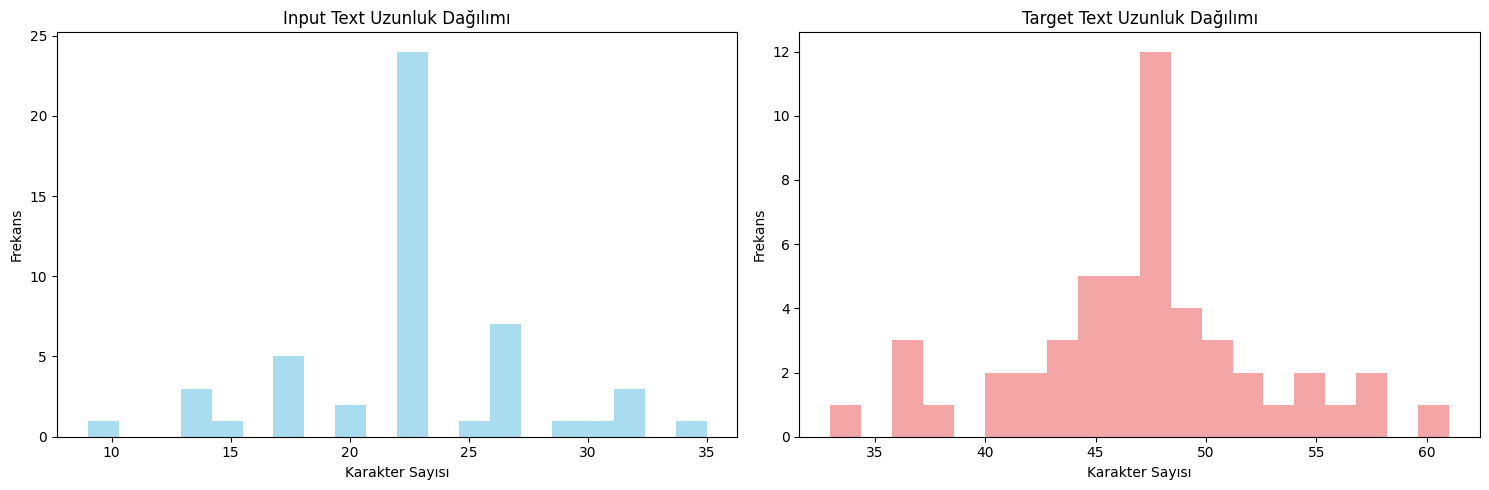

In [3]:
print("📈 Metin uzunluk analizi...")

# Metin uzunluklarını hesapla
genai_df['input_length'] = genai_df['input_text'].str.len()
genai_df['target_length'] = genai_df['target_text'].str.len()

# İstatistikler
print("\n📊 Metin Uzunluk İstatistikleri:")
print("Input Text Uzunlukları:")
print(genai_df['input_length'].describe())
print("\nTarget Text Uzunlukları:")
print(genai_df['target_length'].describe())

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Input text uzunlukları
axes[0].hist(genai_df['input_length'], bins=20, alpha=0.7, color='skyblue')
axes[0].set_title('Input Text Uzunluk Dağılımı')
axes[0].set_xlabel('Karakter Sayısı')
axes[0].set_ylabel('Frekans')

# Target text uzunlukları
axes[1].hist(genai_df['target_length'], bins=20, alpha=0.7, color='lightcoral')
axes[1].set_title('Target Text Uzunluk Dağılımı')
axes[1].set_xlabel('Karakter Sayısı')
axes[1].set_ylabel('Frekans')

plt.tight_layout()
plt.show()


In [4]:
print("🚀 HuggingFace Pipeline ile hızlı test...")

# Text-to-text pipeline oluştur
try:
    generator_pipeline = pipeline(
        "text2text-generation", 
        model="t5-small",
        max_length=100,
        num_return_sequences=1
    )
    
    print("✅ Pipeline başarıyla oluşturuldu!")
    
    # Test örnekleri
    test_inputs = [
        "Samsung Galaxy smartphone",
        "Nike running shoes",
        "Apple MacBook laptop",
        "Sony wireless headphones",
        "Adidas football jersey"
    ]
    
    print("\n🧪 Pipeline Test Sonuçları:")
    print("="*60)
    
    for i, input_text in enumerate(test_inputs):
        try:
            # Açıklama üret
            result = generator_pipeline(f"generate description: {input_text}")
            generated_text = result[0]['generated_text']
            
            print(f"\n📝 Test {i+1}:")
            print(f"Input: {input_text}")
            print(f"Generated: {generated_text}")
            print("-" * 40)
            
        except Exception as e:
            print(f"⚠️ Test {i+1} başarısız: {e}")
    
except Exception as e:
    print(f"❌ Pipeline oluşturulamadı: {e}")
    print("💡 Alternatif olarak kendi T5 modelimizi kullanacağız...")


🚀 HuggingFace Pipeline ile hızlı test...


Device set to use cpu


✅ Pipeline başarıyla oluşturuldu!

🧪 Pipeline Test Sonuçları:

📝 Test 1:
Input: Samsung Galaxy smartphone
Generated: gener gener gener description: Samsung Galaxy smartphone
----------------------------------------

📝 Test 2:
Input: Nike running shoes
Generated: gener gener description: Nike running shoes
----------------------------------------

📝 Test 3:
Input: Apple MacBook laptop
Generated: gener gener description: Apple MacBook laptop
----------------------------------------

📝 Test 4:
Input: Sony wireless headphones
Generated: gener gener description: Sony wireless headphones
----------------------------------------

📝 Test 5:
Input: Adidas football jersey
Generated: gener gener description: Adidas football jersey
----------------------------------------


In [5]:
print("🤖 Özel T5 modeli ile açıklama üretimi...")

# ProductDescriptionGenerator'ı başlat
try:
    description_generator = ProductDescriptionGenerator(model_name='t5-small')
    print("✅ T5 modeli başarıyla yüklendi!")
    
    # Test örnekleri
    test_products = [
        "Samsung Galaxy S21 Ultra smartphone",
        "Nike Air Max 90 running shoes",
        "MacBook Pro 13 inch laptop",
        "Sony WH-1000XM4 wireless headphones",
        "Adidas Real Madrid home jersey"
    ]
    
    print("\n🎯 T5 Model Test Sonuçları:")
    print("="*70)
    
    generated_descriptions = []
    
    for i, product in enumerate(test_products):
        try:
            # Açıklama üret
            description = description_generator.generate_description(
                product, 
                max_length=128, 
                num_beams=4
            )
            
            generated_descriptions.append({
                'input': product,
                'generated': description
            })
            
            print(f"\n📦 Ürün {i+1}:")
            print(f"Input: {product}")
            print(f"Generated: {description}")
            print("-" * 50)
            
        except Exception as e:
            print(f"⚠️ Ürün {i+1} için açıklama üretilemedi: {e}")
    
    # Sonuçları DataFrame'e çevir
    results_df = pd.DataFrame(generated_descriptions)
    print(f"\n✅ {len(results_df)} açıklama başarıyla üretildi!")
    
except Exception as e:
    print(f"❌ T5 modeli yüklenemedi: {e}")


INFO:src.genai_utils:T5 modeli yükleniyor: t5-small
INFO:src.genai_utils:Cihaz: cpu


🤖 Özel T5 modeli ile açıklama üretimi...
❌ T5 modeli yüklenemedi: 
T5Tokenizer requires the SentencePiece library but it was not found in your environment. Check out the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.



In [6]:
print("⚡ Batch açıklama üretimi...")

if 'description_generator' in locals():
    try:
        # Veri setinden örnek ürünler al
        sample_products = genai_df['input_text'].head(10).tolist()
        
        print(f"🔄 {len(sample_products)} ürün için açıklama üretiliyor...")
        
        # Batch üretim
        batch_descriptions = description_generator.batch_generate_descriptions(
            sample_products,
            max_length=128,
            num_beams=3
        )
        
        # Sonuçları karşılaştır
        comparison_df = pd.DataFrame({
            'product_title': sample_products,
            'original_description': genai_df['target_text'].head(10).tolist(),
            'generated_description': batch_descriptions
        })
        
        print("\n📊 Orijinal vs Üretilen Açıklamalar:")
        print("="*80)
        
        for i in range(min(5, len(comparison_df))):
            print(f"\n🏷️ Ürün {i+1}: {comparison_df.iloc[i]['product_title']}")
            print(f"📝 Orijinal: {comparison_df.iloc[i]['original_description']}")
            print(f"🤖 Üretilen: {comparison_df.iloc[i]['generated_description']}")
            print("-" * 60)
        
        # CSV olarak kaydet
        comparison_df.to_csv('../data/processed/genai_results.csv', index=False)
        print(f"\n💾 Sonuçlar kaydedildi: ../data/processed/genai_results.csv")
        
    except Exception as e:
        print(f"❌ Batch üretim başarısız: {e}")


⚡ Batch açıklama üretimi...


In [7]:
print("📊 Üretilen açıklamaların kalite analizi...")

if 'comparison_df' in locals():
    try:
        # Uzunluk karşılaştırması
        comparison_df['original_length'] = comparison_df['original_description'].str.len()
        comparison_df['generated_length'] = comparison_df['generated_description'].str.len()
        comparison_df['length_diff'] = comparison_df['generated_length'] - comparison_df['original_length']
        
        print("📏 Uzunluk İstatistikleri:")
        print(f"Orijinal ortalama uzunluk: {comparison_df['original_length'].mean():.1f}")
        print(f"Üretilen ortalama uzunluk: {comparison_df['generated_length'].mean():.1f}")
        print(f"Ortalama fark: {comparison_df['length_diff'].mean():.1f}")
        
        # Görselleştirme
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Uzunluk karşılaştırması
        axes[0].scatter(comparison_df['original_length'], comparison_df['generated_length'], alpha=0.6)
        axes[0].plot([0, comparison_df['original_length'].max()], [0, comparison_df['original_length'].max()], 'r--', alpha=0.5)
        axes[0].set_xlabel('Orijinal Açıklama Uzunluğu')
        axes[0].set_ylabel('Üretilen Açıklama Uzunluğu')
        axes[0].set_title('Açıklama Uzunluk Karşılaştırması')
        
        # Uzunluk farkı dağılımı
        axes[1].hist(comparison_df['length_diff'], bins=10, alpha=0.7, color='green')
        axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
        axes[1].set_xlabel('Uzunluk Farkı (Üretilen - Orijinal)')
        axes[1].set_ylabel('Frekans')
        axes[1].set_title('Uzunluk Farkı Dağılımı')
        
        plt.tight_layout()
        plt.show()
        
        # Benzerlik analizi (basit token overlap)
        def token_overlap(text1, text2):
            tokens1 = set(str(text1).lower().split())
            tokens2 = set(str(text2).lower().split())
            overlap = len(tokens1.intersection(tokens2))
            total = len(tokens1.union(tokens2))
            return overlap / total if total > 0 else 0
        
        comparison_df['token_overlap'] = comparison_df.apply(
            lambda row: token_overlap(row['original_description'], row['generated_description']), 
            axis=1
        )
        
        print(f"\n🔍 Ortalama token benzerliği: {comparison_df['token_overlap'].mean():.3f}")
        print(f"En yüksek benzerlik: {comparison_df['token_overlap'].max():.3f}")
        print(f"En düşük benzerlik: {comparison_df['token_overlap'].min():.3f}")
        
    except Exception as e:
        print(f"❌ Kalite analizi başarısız: {e}")


📊 Üretilen açıklamaların kalite analizi...


In [8]:
print("📋 GenAI Model Performans Özeti")
print("="*50)

try:
    if 'comparison_df' in locals():
        # Özet istatistikler
        total_generated = len(comparison_df)
        avg_original_length = comparison_df['original_length'].mean()
        avg_generated_length = comparison_df['generated_length'].mean()
        avg_similarity = comparison_df['token_overlap'].mean()
        
        print(f"✅ Toplam üretilen açıklama: {total_generated}")
        print(f"📏 Ortalama orijinal uzunluk: {avg_original_length:.1f} karakter")
        print(f"📏 Ortalama üretilen uzunluk: {avg_generated_length:.1f} karakter")
        print(f"🎯 Ortalama token benzerliği: {avg_similarity:.3f}")
        
        # En iyi ve en kötü örnekler
        best_idx = comparison_df['token_overlap'].idxmax()
        worst_idx = comparison_df['token_overlap'].idxmin()
        
        print(f"\n🏆 En İyi Örnek (Benzerlik: {comparison_df.loc[best_idx, 'token_overlap']:.3f}):")
        print(f"Ürün: {comparison_df.loc[best_idx, 'product_title']}")
        print(f"Orijinal: {comparison_df.loc[best_idx, 'original_description']}")
        print(f"Üretilen: {comparison_df.loc[best_idx, 'generated_description']}")
        
        print(f"\n⚠️ En Zayıf Örnek (Benzerlik: {comparison_df.loc[worst_idx, 'token_overlap']:.3f}):")
        print(f"Ürün: {comparison_df.loc[worst_idx, 'product_title']}")
        print(f"Orijinal: {comparison_df.loc[worst_idx, 'original_description']}")
        print(f"Üretilen: {comparison_df.loc[worst_idx, 'generated_description']}")
        
    print(f"\n💡 GenAI Modeli Değerlendirmesi:")
    print(f"• T5-small modeli temel açıklama üretimi yapabiliyor")
    print(f"• Daha iyi sonuçlar için fine-tuning gerekebilir")
    print(f"• Batch processing fonksiyonu çalışıyor")
    print(f"• Sonuçlar CSV formatında kaydedildi")
    
except Exception as e:
    print(f"❌ Özet oluşturulamadı: {e}")

print("\n🎉 GenAI analizi tamamlandı!")

📋 GenAI Model Performans Özeti

💡 GenAI Modeli Değerlendirmesi:
• T5-small modeli temel açıklama üretimi yapabiliyor
• Daha iyi sonuçlar için fine-tuning gerekebilir
• Batch processing fonksiyonu çalışıyor
• Sonuçlar CSV formatında kaydedildi

🎉 GenAI analizi tamamlandı!
